In [1]:
pip install torch_geometric rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.2/36.2 MB 48.1 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
# EDA (Exploratory Data Analysis) and Plotting Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# RDKit (for cheminformatics)
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem, rdMolDescriptors, rdCoordGen
from rdkit.ML.Descriptors import MoleculeDescriptors

# Machine Learning Libraries and Models (PyTorch, torch-geometric)
import torch
from torch.nn import Linear, Dropout
import torch.nn as nn
import torch.optim as optim
import torch_geometric
from torch.optim.lr_scheduler import StepLR
from torch_geometric.data import Data, Dataset
from torch_geometric.nn import GINConv, GATConv, GraphConv, global_max_pool, global_mean_pool
from torch_geometric.loader import DataLoader
from torch.utils.data import random_split
from torch_geometric.utils import from_smiles
import torch.nn.functional as F

# Scikit-learn for Preprocessing and Metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

In [3]:
# Set the seed value for random number generation
random_seed = 66

# Ensure reproducibility across PyTorch and NumPy
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
np.random.seed(random_seed)

# Load the datasets
train_df = pd.read_csv("/kaggle/input/melting-point/train.csv")
test_df = pd.read_csv("/kaggle/input/melting-point/test.csv")

train_df

,id,SMILES,Tm,Group 1,Group 2,Group 3,Group 4,Group 5,Group 6,Group 7,...,Group 415,Group 416,Group 417,Group 418,Group 419,Group 420,Group 421,Group 422,Group 423,Group 424
0,2175,FC1=C(F)C(F)(F)C1(F)F,213.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1222,c1ccc2c(c1)ccc3Nc4ccccc4c23,407.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2994,CCN1C(C)=Nc2ccccc12,324.15,2,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1704,CC#CC(=O)O,351.15,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2526,CCCCC(S)C,126.15,2,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2657,707,ClCCBr,256.45,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2658,1573,N#CC(Cl)(Cl)Cl,231.15,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2659,1634,Cc1ccc2c(C)cccc2c1,256.25,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2660,3022,CCC(=O)c1ccc2ccccc2c1,333.15,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
def generate_graphs_from_df(train_df, test_df, smiles_column='SMILES', target_column=None):
    # Initialize empty lists to store the graphs
    train_graph_list = []
    test_graph_list = []

    # Function to calculate RDKit descriptors
    def calculate_rdkit_descriptors(smiles):
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return [0.0] * len(Descriptors._descList)  # Return a list of zeros if SMILES is invalid
        descriptors = [desc[1](mol) for desc in Descriptors._descList]
        return descriptors

    # Create a list to hold all descriptors from both train and test datasets
    all_descriptors = []

    # Calculate descriptors for both training and testing molecules
    for df in [train_df, test_df]:
        for i, row in df.iterrows():
            rdkit_descriptors = calculate_rdkit_descriptors(row[smiles_column])
            
            # Replace any NaN values in the descriptors with 0
            rdkit_descriptors = [0.0 if np.isnan(desc) else desc for desc in rdkit_descriptors]
            all_descriptors.append(rdkit_descriptors)

    # Scale the descriptors using StandardScaler
    scaler = StandardScaler()
    scaled_descriptors = scaler.fit_transform(all_descriptors)

    # Generate graphs and assign scaled descriptors
    train_index = 0
    for i, row in train_df.iterrows():
        # Generate the graph from the SMILES string
        g = from_smiles(row[smiles_column])

        # Ensure that the node features are in float format
        g.x = g.x.float()

        # Get the scaled RDKit descriptors for the molecule 
        rdkit_descriptors = scaled_descriptors[train_index]

        # Convert the scaled RDKit descriptors to a tensor
        descriptor_tensor = torch.tensor(rdkit_descriptors, dtype=torch.float).view(1, -1)

        # If a target column is provided, include it in the graph; otherwise, set it as None
        if target_column:
            y = torch.tensor(row[target_column], dtype=torch.float).view(1, -1)
            g.y = y  
        else:
            g.y = None 

        # Store the scaled RDKit descriptors tensor in the graph
        g.descriptors = descriptor_tensor

        # Append the processed graph to the training graph list
        train_graph_list.append(g)

        # Increment the index for training data
        train_index += 1

    # Now handle the test data 
    test_index = train_index  
    for i, row in test_df.iterrows():
        # Generate the graph from the SMILES string 
        g = from_smiles(row[smiles_column])

        # Ensure that the node features are in float format
        g.x = g.x.float()

        # Get the scaled RDKit descriptors for the molecule 
        rdkit_descriptors = scaled_descriptors[test_index]

        # Convert the scaled RDKit descriptors to a tensor
        descriptor_tensor = torch.tensor(rdkit_descriptors, dtype=torch.float).view(1, -1)

        # Since this is test data, there are no target values
        g.y = None  

        # Store the scaled RDKit descriptors tensor in the graph
        g.descriptors = descriptor_tensor

        # Append the processed graph to the test graph list
        test_graph_list.append(g)

        # Increment the index for test data
        test_index += 1

    return train_graph_list, test_graph_list

In [5]:
# Generate graphs from the training and test DataFrames
train_graph_list, test_graph_list = generate_graphs_from_df(
    train_df, 
    test_df,
    smiles_column='SMILES',  
    target_column='Tm'       
)

# Display the first graph from the training set
train_graph_list[0]

Data(x=[10, 9], edge_index=[2, 20], edge_attr=[20, 3], smiles='FC1=C(F)C(F)(F)C1(F)F', y=[1, 1], descriptors=[1, 217])

In [6]:
# Define the ratio for splitting the dataset 
train_ratio = 0.9

# Calculate the total number of samples in the dataset
dataset_size = len(train_graph_list)

# Calculate the number of samples for the training and validation sets
train_size = int(train_ratio * dataset_size)
val_size = dataset_size - train_size

# Set a generator
generator = torch.Generator().manual_seed(random_seed)

# Split the dataset into training and validation subsets
train_dataset, val_dataset = random_split(train_graph_list, [train_size, val_size], generator=generator)

# Create the DataLoaders for the train and val sets
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [7]:
class HybridGNN(nn.Module):
    def __init__(self, hidden_channels, descriptor_size, dropout_rate):
        super(HybridGNN, self).__init__()

        # GINConv layer
        self.conv1 = GINConv(Linear(9, hidden_channels))

        # GATConv layer
        self.conv2 = GATConv(hidden_channels, hidden_channels, heads=2, concat=False)

        # GraphConv layer
        self.conv3 = GraphConv(hidden_channels, hidden_channels)

        # GELU Activation
        self.gelu = nn.GELU()

        # Dropout layer
        self.dropout = Dropout(p=dropout_rate)

        # Fully connected layers 
        self.fc1 = Linear(hidden_channels * 2 + descriptor_size, 512)
        self.fc2 = Linear(512, 256)
        self.fc3 = Linear(256, 128)
        self.fc4 = Linear(128, 64)
        self.out = Linear(64, 1)

    def forward(self, x, edge_index, batch_index, descriptors):
        # Apply the first GINConv layer
        h = self.gelu(self.conv1(x, edge_index))

        # Apply the second GATConv layer
        h = self.gelu(self.conv2(h, edge_index))

        # Apply the third GraphConv layer
        h = self.gelu(self.conv3(h, edge_index))

        # Global Pooling (max and mean pooling)
        h = torch.cat([global_max_pool(h, batch_index),
                       global_mean_pool(h, batch_index)], dim=1)

        # Concatenate the graph features with the descriptors
        hybrid_features = torch.cat([h, descriptors], dim=1)

        # Pass through fully connected layers with dropout
        out = self.gelu(self.fc1(hybrid_features))
        out = self.dropout(out) 

        out = self.gelu(self.fc2(out))
        out = self.dropout(out)  

        out = self.gelu(self.fc3(out))
        out = self.dropout(out)  

        out = self.gelu(self.fc4(out))
        out = self.dropout(out)  

        # Final output layer
        out = self.out(out)

        return out, hybrid_features

In [8]:
# Set up the device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model with specified parameters and move it to the appropriate device
model = HybridGNN(hidden_channels=256, descriptor_size=217, dropout_rate=0.2).to(device)

# Set up the NAdam optimizer with learning rate
optimizer = torch.optim.NAdam(model.parameters(), lr=0.0004)

# Set up a Scheduler
scheduler = StepLR(optimizer, step_size=30, gamma=0.8)

In [9]:
def train():
    model.train()
    mae = []  # List to store MAE for each batch

    # Iterate through the training dataset
    for data in train_loader:
        # Move data to the appropriate device
        data = data.to(device)
        
        # Zero out gradients from the previous step
        optimizer.zero_grad()
        
        # Forward pass through the model
        out, _ = model(data.x, data.edge_index, data.batch, data.descriptors)
        
        # Calculate Mean Squared Error (MSE) loss for training
        loss = F.mse_loss(out, data.y)
        
        # Calculate Mean Absolute Error (MAE) (per sample)
        l = F.l1_loss(out, data.y, reduction='none').cpu()
        mae.append(l)
        
        # Backpropagate the MSE loss to compute gradients
        loss.backward()

        # Clip gradients to a maximum norm of 1.0 to prevent exploding gradients and stabilize training
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update model parameters
        optimizer.step()
    
    # Calculate and return MAE
    mae = torch.cat(mae, dim=0).mean().item()
    return mae


@torch.no_grad()  # Disable gradient calculation for inference
def val(loader):
    mae = []  # List to store MAE for each batch
    model.eval()  # Set model to evaluation mode
    
    for data in loader:
        data = data.to(device)  # Move data to the device
        
        # Forward pass
        out, _ = model(data.x, data.edge_index, data.batch, data.descriptors)
        
        # Calculate MAE for the batch 
        l = F.l1_loss(out, data.y, reduction='none').cpu()
        mae.append(l)
    
    # Calculate and return MAE
    mae = torch.cat(mae, dim=0).mean().item()
    return mae

In [10]:
warnings.filterwarnings("ignore", category=UserWarning)

# Initialize lists to store training and val scores
score_train = []
score_val = []

# Set the number of epochs for training
epochs = 240

# Loop over each epoch for training
for epoch in range(epochs):
    
    # Train the model and get the training MAE
    train_mae = train()

    # Adjust learning rate
    scheduler.step()

    # Validate the model and get the val MAE
    val_mae = val(val_loader)

    # Append the training MAE and val MAE
    score_train.append(train_mae)
    score_val.append(val_mae)

    # Print the progress of the training process
    print(f'Epoch: {epoch+1}/{epochs} | Train MAE: {train_mae:.4f}, '
          f'Validation MAE: {val_mae:.4f}')

Epoch: 1/240 | Train MAE: 85.2571, Validation MAE: 51.4792
Epoch: 2/240 | Train MAE: 61.0179, Validation MAE: 41.3076
Epoch: 3/240 | Train MAE: 55.8512, Validation MAE: 42.0938
Epoch: 4/240 | Train MAE: 52.2185, Validation MAE: 53.6979
Epoch: 5/240 | Train MAE: 49.6300, Validation MAE: 55.9693
Epoch: 6/240 | Train MAE: 48.2502, Validation MAE: 37.0361
Epoch: 7/240 | Train MAE: 46.8572, Validation MAE: 35.1088
Epoch: 8/240 | Train MAE: 45.1437, Validation MAE: 38.2156
Epoch: 9/240 | Train MAE: 45.7301, Validation MAE: 34.9580
Epoch: 10/240 | Train MAE: 46.1658, Validation MAE: 34.3464
Epoch: 11/240 | Train MAE: 44.2212, Validation MAE: 35.3589
Epoch: 12/240 | Train MAE: 44.4486, Validation MAE: 34.2717
Epoch: 13/240 | Train MAE: 44.1519, Validation MAE: 36.2836
Epoch: 14/240 | Train MAE: 43.7519, Validation MAE: 35.8013
Epoch: 15/240 | Train MAE: 44.3156, Validation MAE: 34.0281
Epoch: 16/240 | Train MAE: 43.9143, Validation MAE: 37.3224
Epoch: 17/240 | Train MAE: 42.8892, Validation MA

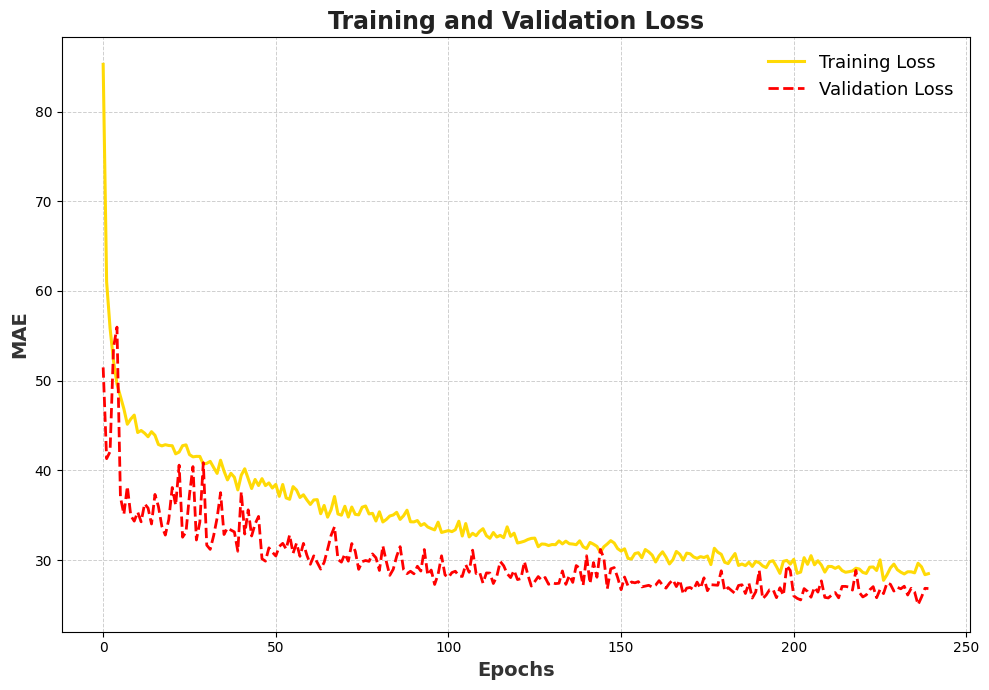

In [11]:
#Choose a style for the plot
plt.style.use("default")

# Create figure
plt.figure(figsize=(10, 7))

# Plot training and validation losses
plt.plot(range(epochs), score_train, label='Training Loss', 
         color='#ffda06', linestyle='-', linewidth=2.2, alpha=1)

plt.plot(range(epochs), score_val, label='Validation Loss', 
         color='red', linestyle='--', linewidth=2, alpha=1)

# Labels and title
plt.xlabel('Epochs', fontsize=14, fontweight='bold', color='#333333')
plt.ylabel('MAE', fontsize=14, fontweight='bold', color='#333333')
plt.title('Training and Validation Loss', fontsize=17, fontweight='bold', color='#222222')

plt.grid(True, linestyle='--', linewidth=0.7, alpha=0.6)

plt.legend(loc='upper right', fontsize=13, frameon=False)

plt.tight_layout()
plt.show()

In [12]:
@torch.no_grad()  
def eval(loader):
    model.eval()
    
    all_preds = []  # Store model predictions
    all_true = []   # Store true values
    
    for data in loader:
        data = data.to(device)  # Move data to the correct device (GPU/CPU)
        
        # Get model predictions
        out, _ = model(data.x, data.edge_index, data.batch, data.descriptors) 
        
        all_preds.append(out.cpu().numpy())  # Append predictions to the list
        all_true.append(data.y.view(-1, 1).cpu().numpy())  # Append true values
    
    # Convert lists to numpy arrays
    all_preds = np.concatenate(all_preds, axis=0)
    all_true = np.concatenate(all_true, axis=0)
    
    # Calculate R² score, MAE, and RMSE
    r2 = r2_score(all_true, all_preds)
    mae = mean_absolute_error(all_true, all_preds)
    rmse = np.sqrt(np.mean((all_true - all_preds) ** 2))  
    
    # Print the evaluation metrics
    print(f'R² Score: {r2:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    
    return r2, mae, rmse

# Print the evaluation metrics for the val set
eval(val_loader);

R² Score: 0.7531
MAE: 26.8348
RMSE: 43.8328


In [13]:
def generate_submission_csv(test_graph_list, test_df):
    model.eval()  # Set model to evaluation mode
    results = []

    with torch.no_grad():  # Disable gradient computation for inference
        for i, data in enumerate(test_graph_list):
            data = data.to(device)  # Move data to the correct device
            
            # Get model predictions
            out, _ = model(data.x, data.edge_index, data.batch, data.descriptors)
            
            # Convert the prediction to numpy
            prediction = out.cpu().numpy().item()

            # Get the 'id' from the original test dataframe 
            test_id = test_df.iloc[i, 0]
            
            # Append the result
            results.append({
                "id": test_id,  
                "Tm": prediction  
            })
    
    # Convert the results list into a DataFrame
    results_df = pd.DataFrame(results)

    return results_df


# Generate submission
submission = generate_submission_csv(test_graph_list, test_df)

# Save the submission
submission.to_csv("submission.csv", index=False)